# 1D Burgers Example

In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from itertools import product
import sys,time
import os
import pickle
from WLaSDI import WLaSDI
from WLaSDI_wendy import WLaSDI_wendy
import matplotlib
from scipy.interpolate import interp2d, Rbf

### Load data 

In [6]:
# ### Load Data if Model Already Exists ###
# training data
snapshot_full = pickle.load(open("./snapshot_git.p", 'rb'))
snapshot_full = snapshot_full[:,:-1].astype('float32')

# testing parameters and data
amp_test = np.array([0.8])
width_test = np.array([1.0])
snapshot_full_FOM = pickle.load(open(f"./FOM_a{amp_test[0]}_w{width_test[0]}.p",'rb'))
FOM_time = snapshot_full_FOM['time']
snapshot_full_FOM = snapshot_full_FOM['FOM'][:,:-1].astype('float32')

In [7]:
def addNoise(x, noise_ratio):
    signal_power = np.sqrt(np.mean(x**2))
    sigma = noise_ratio*signal_power
    noise = np.random.normal(0, sigma, x.shape)
    xobs = x + noise
    return xobs
snapshot_full = addNoise(snapshot_full, 0.0).astype('float32')

### Applying POD

In [15]:
u,s,vh = LA.svd(snapshot_full.T)
sv_mass = np.cumsum(s)
sv_count = 5 #[i for i,ss in enumerate(sv_mass) if ss/sv_mass[-1]>.99][0]+1
s[sv_count:] = 0
#print(sv_count, sv_mass[:sv_count]/sv_mass[-1])
phi = u[:,:sv_count]

nx = 1001
dx = 6 / (nx - 1)
nt = 1000
tstop = 1
x=np.linspace(-3, 3, nx)

dt = tstop / nt 
c = dt/dx
t = np.linspace(0, tstop, nt+1)

### Transform training data into latent-space trajectories

In [17]:
amp_arr = np.array([0.75,0.85])
width_arr = np.array([0.95,1.05])
P = list(product(amp_arr, width_arr))
P = np.array(P)

ndata = snapshot_full.shape[0]
nset = int(ndata/(nt+1))

latent_space_LS_list = []

for foo in range(nset):
    latent_space_LS = np.matmul(phi.T, snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].T).T
    latent_space_LS_list.append(latent_space_LS)

## Applying WLaSDI

/Users/chtr8711/Documents/GitHub/WLaSDI/LaSDI/lasdi_venv/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "


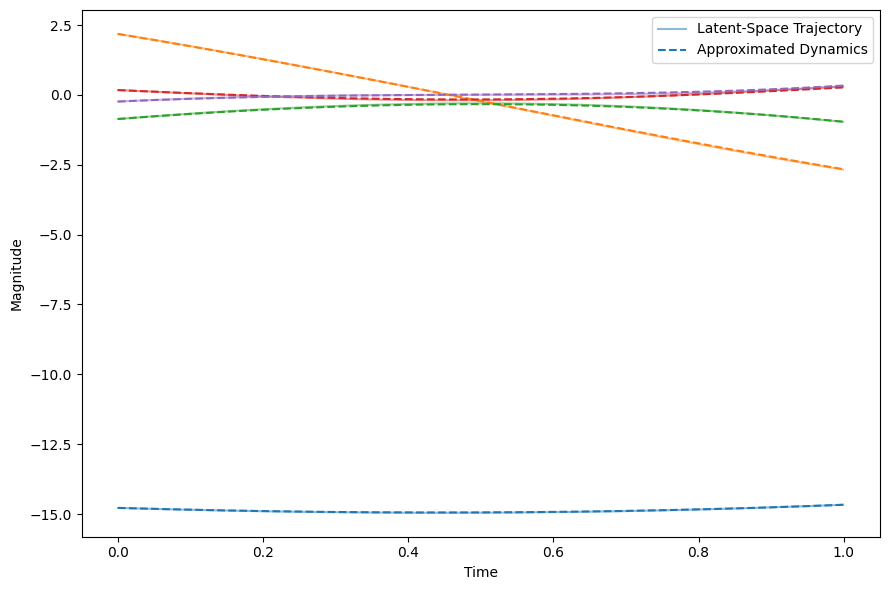

In [18]:
#Using WSINDy
degree = 1
normal = 1
WLaSDI_model = WLaSDI(phi.T, phi, Local=False, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh=9)
WLaSDI_model_coef = WLaSDI_model.train_dynamics(latent_space_LS_list, P, t, degree = degree, gamma = 0.001, threshold=0, overlap=0.7, L = 30, LS_vis=True)

mt_min None


/Users/chtr8711/Documents/GitHub/WLaSDI/LaSDI/1D_Burgers/../WENDy.py:636: RuntimeWarning: invalid value encountered in double_scalars
  m = (U[-1] - U[0]) / (x[-1] - x[0])
/Users/chtr8711/Documents/GitHub/WLaSDI/LaSDI/lasdi_venv/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


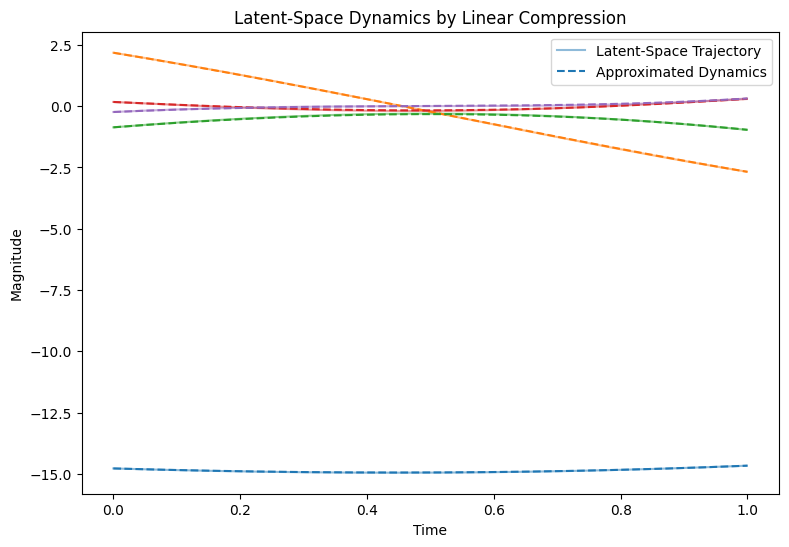

In [20]:
#Using WENDy
features = [
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
        [lambda x0, x1, x2, x3, x4: x0*0 + 1, lambda x0, x1, x2, x3, x4: x0, lambda x0, x1, x2, x3, x4: x1, lambda x0, x1, x2, x3, x4: x2, lambda x0, x1, x2, x3, x4: x3, lambda x0, x1, x2, x3, x4: x4],
]

degree = 1
normal = 1#np.amax(np.abs(latent_space_LS_list))
WLaSDI_model = WLaSDI_wendy(phi.T, phi, Local = False, Coef_interp=False, Coef_interp_method=Rbf, nearest_neigh = 4)
WLaSDI_model_coef = WLaSDI_model.train_dynamics(latent_space_LS_list, P, t, features = features, normal = normal, gamma = 0.01, LS_vis = True, ls_meth = "LS", subsample=1, mt_params=[2**i for i in range(4)], toggle_VVp_svd = np.nan)

## Generate ROM and visualize results

Final Position Error: 0.537%


Text(0, 0.5, 'Relative Error (%)')

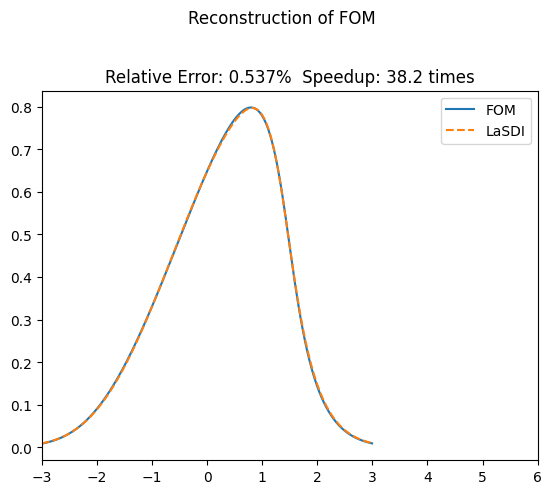

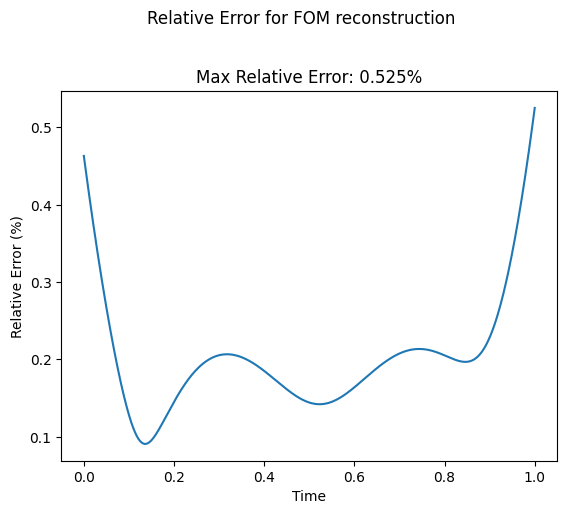

In [21]:
start = time.time()
FOM_recon = WLaSDI_model.generate_ROM(snapshot_full_FOM[0], np.hstack((amp_test,width_test)),t)
LaSDI_time = time.time()-start

print('Final Position Error: {:.3}%'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100))
fig = plt.figure()
ax = plt.axes()
fig.suptitle('Reconstruction of FOM', y = 1.05)
ax.set_title('Relative Error: {:.3}%  Speedup: {:.3} times'.format(LA.norm(FOM_recon[-1]-snapshot_full_FOM[-2])/LA.norm(snapshot_full_FOM[-2])*100, FOM_time/LaSDI_time))
ax.plot(x[:-1],snapshot_full_FOM[-1], label = 'FOM')
ax.plot(x[:-1], FOM_recon[-1],'--', label = 'LaSDI')
ax.legend()
ax.set_xlim(-3,6)


FOM_re = np.empty(nt+1)
for i in range(nt+1):
    FOM_re[i] = LA.norm(FOM_recon[i]-snapshot_full_FOM[i])/LA.norm(snapshot_full_FOM[i])

fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction', y = 1.05)
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_re)*100))
ax.plot(t, FOM_re*100)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')
# torch.cuda.empty_cache()